In [80]:
import blocksci

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import seaborn as sns

In [4]:
plt.rcParams['figure.figsize'] = (12.5, 10)

In [5]:
from statistics import mode

In [6]:
from addressanalysis import received_outs_without_change

In [7]:
import random

In [8]:
chain = blocksci.Blockchain("/blocksci/btc.json")

In [9]:
len(chain)

637091

## New Taint Analysis - Helper Functions

In [10]:
taint_policies = {
    "Poison": blocksci.heuristics.poison_tainted_outputs,
    "Haircut": blocksci.heuristics.haircut_tainted_outputs,
    "Fifo": blocksci.heuristics.fifo_tainted_outputs,
    "Fifo+Seniority": blocksci.heuristics.fifo_seniority_tainted_outputs,
    "Seniority": blocksci.heuristics.seniority_tainted_outputs,
    "Juniority": blocksci.heuristics.juniority_tainted_outputs,
    "Tiho": blocksci.heuristics.tiho_tainted_outputs
}

In [11]:
taint_policies_efficient = {
    "Fifo": blocksci.heuristics.fifo_tainted_outputs,
    "Fifo+Seniority": blocksci.heuristics.fifo_seniority_tainted_outputs,
    "Seniority": blocksci.heuristics.seniority_tainted_outputs,
    "Juniority": blocksci.heuristics.juniority_tainted_outputs,
    "Tiho": blocksci.heuristics.tiho_tainted_outputs
}

In [12]:
def run_taint(outs, runall=False, taint_fee=True, max_height=610695):
    if runall:
        return [taint_policies[n](outs, taint_fee=taint_fee, max_block_height=max_height) for n in taint_policies]
    else:
        return [taint_policies_efficient[n](outs, taint_fee=taint_fee, max_block_height=max_height) for n in taint_policies_efficient]

In [190]:
for n in taint_policies_efficient:
    print(n)

Fifo
Fifo+Seniority
Seniority
Juniority
Tiho


In [13]:
def extract_taint_values(lst, sum_chunks=True):
    values = []
    for elem in lst:
        taint = elem[1]
        if isinstance(taint, list):  # fifo
            v = [t[0] for t in taint if t[1]]
            if sum_chunks:
                values.append(sum(v))
            else:
                values.extend(v)
        else:
            values.append(taint[0])
    return values

In [14]:
def extract_output_values(lst):
    if isinstance(lst[0][1], list):
        return [sum(y for y, _ in x[1]) for x in lst]
    else:
        return [sum(x[1]) for x in lst]

In [15]:
def extract_output_timestamp(lst):
    return [x[0].tx.block.time for x in lst]

In [16]:
def extract_taint_time(lst):
    return list(zip(extract_output_timestamp(lst), extract_taint_values(lst)))

In [17]:
def value_hist(values, ymax=None, label=None):
    bins = [0.25 * x for x in range(45)]
    ax = sns.distplot(np.log10(values), bins=bins, kde=False, norm_hist=False, label=label, axlabel="Output value (log10)")
    ax.set(xlim=(0, 11), ylim=(0, ymax))
    sns.despine()

In [18]:
def perc_hist(values, ymax=None, label=None):
    bins = [0.025 * x for x in range(41)]
    ax = sns.distplot(values, bins=bins, kde=False, norm_hist=False, label=label, axlabel="Share of output value tainted")
    #ax.set(xlim=(0, 1), ylim=(0, ymax))
    sns.despine()

In [19]:
from matplotlib.dates import DateFormatter, MonthLocator

def value_age_lineplot(df, ymax=None, label=None, month_ticks=False):
    df.columns = [label]
    ax = sns.lineplot(df.index, df[label], label=label)
    ax.set(ylim=(0, ymax))
    ax.set(xlabel='Tainted UTXO creation date', ylabel="Tainted value (in BTC)")

    if month_ticks:
        ax.xaxis.set_major_locator(MonthLocator(month_ticks))
    ax.xaxis.set_major_formatter(DateFormatter('%m/%y'))
    
    sns.despine()

In [20]:
def all_taint_value_hist(taint, ymax=None, filename="default.pdf"):
    f = extract_taint_values
    p = plt.figure(figsize=(16,4))
    plt.subplot(1, 4, 1)
    value_hist(f(taint[0]), ymax=ymax, label="FIFO (per output)")
    value_hist(f(taint[0], sum_chunks=False), ymax=ymax, label="FIFO (chunks)")
    plt.legend(frameon=False)
    
    plt.subplot(1, 4, 2)
    value_hist(f(taint[1]), ymax=ymax, label="Output-Seniority")
    plt.legend(frameon=False)
    
    plt.subplot(1, 4, 3)
    value_hist(f(taint[2]), ymax=ymax, label="Seniority")
    value_hist(f(taint[3]), ymax=ymax, label="Juniority")
    plt.legend(frameon=False)
    
    plt.subplot(1, 4, 4)
    value_hist(f(taint[4]), ymax=ymax, label="TIHO")
    plt.legend(frameon=False)
    
    p.savefig(filename, bbox_inches='tight')

In [21]:
def all_output_value_hist(taint, ymax=None, filename="default.pdf"):
    f = extract_output_values
    p = plt.figure(figsize=(16,4))
    plt.subplot(1, 4, 1)
    value_hist(f(taint[0]), ymax=ymax, label="FIFO")
    plt.legend(frameon=False)
    
    plt.subplot(1, 4, 2)
    value_hist(f(taint[1]), ymax=ymax, label="Output-Seniority")
    plt.legend(frameon=False)
    
    plt.subplot(1, 4, 3)
    value_hist(f(taint[2]), ymax=ymax, label="Seniority")
    value_hist(f(taint[3]), ymax=ymax, label="Juniority")
    plt.legend(frameon=False)
    
    plt.subplot(1, 4, 4)
    value_hist(f(taint[4]), ymax=ymax, label="TIHO")
    plt.legend(frameon=False)
    
    p.savefig(filename, bbox_inches='tight')

In [22]:
def tainted_share_hist(taint, ymax=None, filename="default.pdf"):
    f = extract_taint_values
    g = extract_output_values
    
    share = lambda x: [t/f for t,f in zip(f(x), g(x))]
    
    p = plt.figure(figsize=(16,4))
    plt.subplot(1, 4, 1)
    perc_hist(share(taint[0]), ymax=ymax, label="FIFO")
    plt.legend(frameon=False)
    
    plt.subplot(1, 4, 2)
    perc_hist(share(taint[1]), ymax=ymax, label="Output-Seniority")
    plt.legend(frameon=False)
    
    plt.subplot(1, 4, 3)
    perc_hist(share(taint[2]), ymax=ymax, label="Seniority")
    perc_hist(share(taint[3]), ymax=ymax, label="Juniority")
    plt.legend(frameon=False)

    plt.subplot(1, 4, 4)
    perc_hist(share(taint[4]), ymax=ymax, label="TIHO")
    plt.legend(frameon=False)
    
    p.savefig(filename, bbox_inches='tight')

In [23]:
def taint_age_lineplot(taint, ymax=None, month_ticks=False, filename="default.pdf"):
    get_df = lambda x: pd.DataFrame({"timestamp": extract_output_timestamp(x), "value": extract_taint_values(x)}).groupby("timestamp").sum().resample("1 d").sum().cumsum().div(int(1e8))
    
    p = plt.figure(figsize=(16,4))
    plt.subplot(1, 4, 1)
    value_age_lineplot(get_df(taint[0]), ymax=ymax, label="FIFO", month_ticks=month_ticks)
    plt.legend(frameon=False)
    
    plt.subplot(1, 4, 2)
    value_age_lineplot(get_df(taint[1]), ymax=ymax, label="Output-Seniority", month_ticks=month_ticks)
    plt.legend(frameon=False)
    
    plt.subplot(1, 4, 3)
    value_age_lineplot(get_df(taint[2]), ymax=ymax, label="Seniority", month_ticks=month_ticks)
    value_age_lineplot(get_df(taint[3]), ymax=ymax, label="Reversed seniority", month_ticks=month_ticks)
    plt.legend(frameon=False)
    
    plt.subplot(1, 4, 4)
    value_age_lineplot(get_df(taint[4]), ymax=ymax, label="TIHO", month_ticks=month_ticks)
    plt.legend(frameon=False)
    
    p.savefig(filename, bbox_inches='tight')

In [24]:
def fifo_sum(p):
    t = p[1]
    return sum(v for v, b in t if b)

In [25]:
def fifo_chunk_count_output(o):
    t = o[1]
    return len([b for _, b in t if b])

In [26]:
def fifo_chunk_count(t):
    return sum(fifo_chunk_count_output(x) for x in t)

In [27]:
def seniority_sum(p):
    return p[1][0]
def simple_taint_value(p):
    return p[1][0]

In [28]:
def total_fifo_taint(x):
    return sum(fifo_sum(y) for y in x)

def total_simple_taint(x):
    return sum(simple_taint_value(y) for y in x)

In [94]:
def count_taint(t, runall=False, do_print=True):
    counts = [len(x) for x in t]
    if do_print:
        formatted = [f"{x:,}" for x in counts]
        print(*formatted, sep = " & ")
    return counts

In [212]:
def count_taint_no_dust(t, do_print=True):
    counts = [len([y for y in x if y[0].value > 546]) for x in t]
    if do_print:
        formatted = [f"{x:,}" for x in counts]
        print(*formatted, sep = " & ")
    return counts

In [30]:
def count_taint_greater(t, v):
    counts = [len([True for x in t[0] if fifo_sum(x) > v])]
    for i in range(1, len(t)):
        counts.append(len([True for x in t[i] if seniority_sum(x) > v]))
    print(*counts, sep = " & ") 
    return counts

In [51]:
def no_fee_taint_loss(with_fees, no_fees):
    lost_taint = []
    fifo_with_fees = total_fifo_taint(with_fees[0])
    fifo_no_fees = total_fifo_taint(no_fees[0])
    lost_taint.append((fifo_with_fees, fifo_no_fees))
    
    for i in range(1, len(with_fees)):
        lost_taint.append((total_simple_taint(with_fees[i]), total_simple_taint(no_fees[i])))
    #print([(x-y) / 1e8 for x,y in lost_taint])
    print(*[round(100 * (x-y)/x, 2) for x,y in lost_taint], sep = " & ")
    return lost_taint

In [81]:
def output_time_range(outs):
    ts = [x.tx.block.time for x in outs]
    return min(ts), max(ts)

In [129]:
def latex_table_format(lst, round_digits=None):
    if round_digits:
        print(*[round(x, round_digits) for x in lst], sep = " & ")
    else:
        print(*lst, sep = " & ")

## Set max height

In [32]:
max_height_analysis = 637091

## Addresses extracted from blackmail scam mails

In [33]:
blackmail_address_strings = set([
    "16oE4aRiJQvwMvbdfkx6kX8Wg9GLA1uFnz",
    "1Agq5LZhY2UgcHoknVU7rZeE1x4gMuJTvf",
    "13bpFXeCW6inWQSSgkVKj9rmemtkNvNoD3",
    "1GPjEBZvfFRAGwCorR98upF5ByDu2Cq9Ha",
    "18921mhD7bedjrgQuDmNh3oFuMQiUry1X7",
    "1B3SBdx6ZqhBjUuYTzoMZq4a6Kvk4psKfM",
    "19qL8vdRtk5xJcGNVk3WruuSyitVfSAy7f",
    "1KzMDhZLokkNd1kcxs2mgwXm97pVvnfRBC",
    "1P7bLeCJywaaDRQpT7iwb4qzUHa4CpRFyP",
    "1971pHPgLaTmuYtoH4BsGSfFMZaAjotium",
    "17EuB8AmyBm81FgCovdr6huCCoSzv2S7nP",
    "1WLEChY6S7S97m5voZZtbQcwiEYeSNsja",
    "13phdoBirrAtFXKWJQ9HgTYX9b7C2MqXPE",
    "1G1qFoadiDxa7zTvppSMJhJi63tNUL3cy7",
    "18Pt4B7Rz7Wf491FGQHPsfDeKRqnkyrMo6",
    "3ER3byGWbnqgxN4C5amtCXHExPgGaUWsBd",
    "19UW5P6PGDA3SWehh8UMGQQC3ezBzN1mDE",
    "1H1K8MfLEJgjCCfDEkTJmv9GJjD3XzEFGR",
    "39eaJ2Fxbm4KWVu26BzaEH465aK4yrbuzH",
    "38KxdSNjge7hdy7zWZuRRC4hN4krQrrA5b",
    "12s4cfoNTzT68gSdxLjmSRT3qdvaqwDWNz",
    "1GoWy5yMzh3XXBiYxLU9tKCBMgibpznGio",
    "15mWFjVymAdqimVim2f1UgX6oSD4TYeGLE",
    "1ELgYTbMLmw9vaHADfZmMcKVMWCNmRH8S2",
    "1Gm6q6M2TfL4yrL3TnvsUZZ1C5k6wrvBbX",
    "34vhBcVUYwfNYjupWHrzef1zogaRZaSFU6",
    "3CEx39owi6EeUAoM4ENyYdGhLZj7nAwuYH",
    "1DjuN5PM9VLXCeqYrb9nxzpQ8rb2hXZiEt"
])

In [34]:
blackmail_addresses = [chain.address_from_string(x) for x in blackmail_address_strings]
blackmail_addresses = [x for x in blackmail_addresses if x]

In [35]:
blackmail_addresses

[PubkeyHashAddress(1Agq5LZhY2UgcHoknVU7rZeE1x4gMuJTvf),
 PubkeyHashAddress(1ELgYTbMLmw9vaHADfZmMcKVMWCNmRH8S2),
 PubkeyHashAddress(1H1K8MfLEJgjCCfDEkTJmv9GJjD3XzEFGR),
 PubkeyHashAddress(1P7bLeCJywaaDRQpT7iwb4qzUHa4CpRFyP),
 PubkeyHashAddress(19UW5P6PGDA3SWehh8UMGQQC3ezBzN1mDE),
 PubkeyHashAddress(1B3SBdx6ZqhBjUuYTzoMZq4a6Kvk4psKfM),
 PubkeyHashAddress(13bpFXeCW6inWQSSgkVKj9rmemtkNvNoD3),
 PubkeyHashAddress(15mWFjVymAdqimVim2f1UgX6oSD4TYeGLE),
 PubkeyHashAddress(1GoWy5yMzh3XXBiYxLU9tKCBMgibpznGio),
 PubkeyHashAddress(1WLEChY6S7S97m5voZZtbQcwiEYeSNsja),
 PubkeyHashAddress(1G1qFoadiDxa7zTvppSMJhJi63tNUL3cy7),
 PubkeyHashAddress(12s4cfoNTzT68gSdxLjmSRT3qdvaqwDWNz),
 PubkeyHashAddress(19qL8vdRtk5xJcGNVk3WruuSyitVfSAy7f),
 PubkeyHashAddress(1971pHPgLaTmuYtoH4BsGSfFMZaAjotium),
 PubkeyHashAddress(18921mhD7bedjrgQuDmNh3oFuMQiUry1X7),
 PubkeyHashAddress(1KzMDhZLokkNd1kcxs2mgwXm97pVvnfRBC),
 PubkeyHashAddress(16oE4aRiJQvwMvbdfkx6kX8Wg9GLA1uFnz),
 PubkeyHashAddress(18Pt4B7Rz7Wf491FGQHPsfDeKRqnky

In [36]:
import itertools
blackmail_outs = list(itertools.chain(*[list(x.outs.where(lambda o: o.tx.block_height <= max_height_analysis)) for x in blackmail_addresses]))

In [37]:
len(blackmail_outs)

273

In [38]:
blackmail_outs_nochange = list(itertools.chain(*[received_outs_without_change(x) for x in blackmail_addresses]))  # no difference

In [39]:
len(blackmail_outs_nochange)

273

In [40]:
blackmail_taint = run_taint(blackmail_outs_nochange, max_height=max_height_analysis)

In [46]:
count_taint(blackmail_taint)

2,821 & 11,913 & 22,215 & 10,330 & 304


[2821, 11913, 22215, 10330, 304]

In [42]:
blackmail_taint_nofee = run_taint(blackmail_outs_nochange, taint_fee=False, max_height=max_height_analysis)

In [47]:
count_taint(blackmail_taint_nofee)

1,764 & 9,980 & 20,573 & 9,964 & 241


[1764, 9980, 20573, 9964, 241]

In [52]:
no_fee_taint_loss(blackmail_taint, blackmail_taint_nofee)

1.06 & 2.64 & 1.38 & 0.69 & 0.09


[(2880478282, 2849864978),
 (2880478282, 2804454345),
 (2880478282, 2840794030),
 (2880478282, 2860665165),
 (2880478282, 2877981445)]

In [213]:
count_taint_no_dust(blackmail_taint)

2,753 & 10,806 & 19,469 & 5,096 & 304


[2753, 10806, 19469, 5096, 304]

### Plots

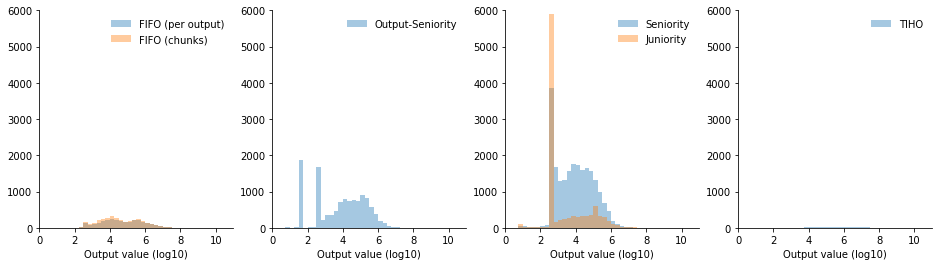

In [234]:
all_taint_value_hist(blackmail_taint, 6000, "figures/blackmail_taint_hist.pdf")

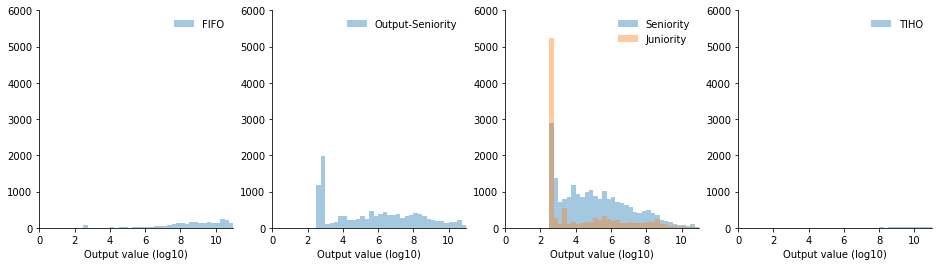

In [235]:
all_output_value_hist(blackmail_taint, 6000, "figures/blackmail_value_hist.pdf")

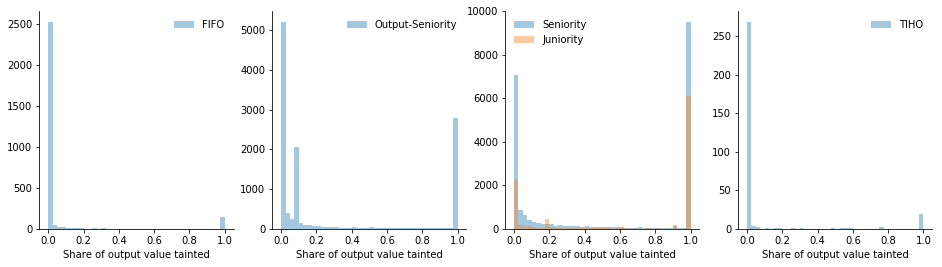

In [236]:
tainted_share_hist(blackmail_taint, 8000, "figures/blackmail_share_hist.pdf")

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


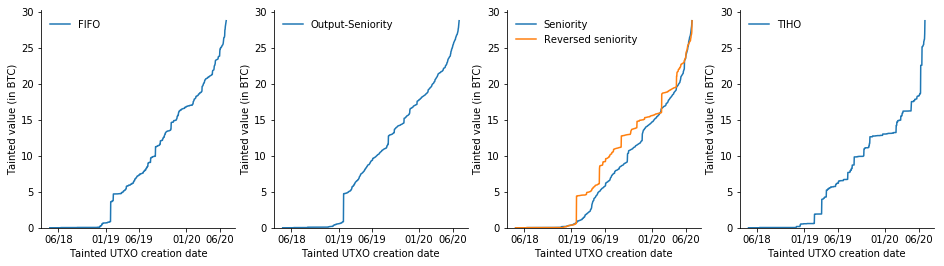

In [237]:
taint_age_lineplot(blackmail_taint, filename="figures/blackmail_age_lineplot.pdf", month_ticks=[1,6])

### Poison/Haircut

In [217]:
%time blackmail_poison_count = blocksci.heuristics.poison_tainted_output_count(blackmail_outs_nochange)

CPU times: user 12min 3s, sys: 3.22 s, total: 12min 6s
Wall time: 12min 2s


In [218]:
%time blackmail_haircut_count = blocksci.heuristics.haircut_tainted_output_count(blackmail_outs_nochange)

CPU times: user 7min 8s, sys: 1.25 s, total: 7min 10s
Wall time: 7min 7s


In [219]:
blackmail_poison_count, blackmail_haircut_count

(32743834, 11290000)

### Impact of Colored Coins

In [189]:
len([x for x in blackmail_taint[3] if x[0].value == 546 and x[0].tx.op_return and x[0].tx.op_return.address.data[:4] == b'omni'])

4850

In [179]:
x = blackmail_taint[3][5000][0].tx.op_return.address.data

In [187]:
blackmail_taint[3][5000][0].tx.outputs[1].address.data[0:4] == b'omni'

True

## OFAC Outputs

In [53]:
ofac1 = chain.address_from_string("149w62rY42aZBox8fGcmqNsXUzSStKeq8C")
ofac2 = chain.address_from_string("1AjZPMsnmpdK2Rv9KQNfMurTXinscVro9V")

In [54]:
ofac_outs = ofac1.outputs.where(lambda o: o.tx.block_height <= max_height_analysis).to_list() + ofac2.outputs.where(lambda o: o.tx.block_height <= max_height_analysis).to_list()

In [55]:
len(ofac_outs)

6983

In [56]:
# remove change outputs
ofac_outs = received_outs_without_change(ofac1).where(lambda o: o.tx.block_height <= max_height_analysis).to_list() + received_outs_without_change(ofac2).where(lambda o: o.tx.block_height <= max_height_analysis).to_list()

In [57]:
%time ofac_taint = run_taint(ofac_outs, max_height=max_height_analysis)

CPU times: user 4min 56s, sys: 5.32 s, total: 5min 1s
Wall time: 5min 9s


In [58]:
%time ofac_taint_nofee = run_taint(ofac_outs, max_height=max_height_analysis, taint_fee=False)

CPU times: user 3min 31s, sys: 488 ms, total: 3min 31s
Wall time: 3min 30s


In [ ]:
len([True for x in ofac_taint[0] if x[0].value == 546])

In [ ]:
len(ofac_taint)

In [59]:
# tainting fees
count_taint(ofac_taint)

270,537 & 451,581 & 870,672 & 456,477 & 29,963


[270537, 451581, 870672, 456477, 29963]

In [ ]:
count_taint_greater(ofac_taint, v=9900)

In [60]:
no_fee_taint_loss(ofac_taint, ofac_taint_nofee)

2.02 & 4.75 & 3.63 & 1.88 & 0.26


[(587065023955, 575218900689),
 (587028718398, 559153667601),
 (586940840551, 565653516394),
 (587178212009, 576164142053),
 (587279837809, 585753186254)]

In [214]:
count_taint_no_dust(ofac_taint)

268,233 & 405,304 & 815,523 & 351,604 & 29,774


[268233, 405304, 815523, 351604, 29774]

#### Validation (No taint lost during tainting)

In [38]:
total_ofac_out_value = sum([x.value for x in ofac_outs])
total_ofac_out_value

590140699176

In [42]:
sum([fifo_sum(x) for x in ofac_taint[0]]) + 3075675221 == total_ofac_out_value

True

In [43]:
sum([seniority_sum(x) for x in ofac_taint[1]]) + 3111980778 == total_ofac_out_value

True

In [44]:
sum([seniority_sum(x) for x in ofac_taint[2]]) + 3199858625 == total_ofac_out_value

True

In [45]:
sum([seniority_sum(x) for x in ofac_taint[3]]) + 2962487167 == total_ofac_out_value

True

In [46]:
sum([seniority_sum(x) for x in ofac_taint[4]]) + 2860861367 == total_ofac_out_value

True

#### Plots

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


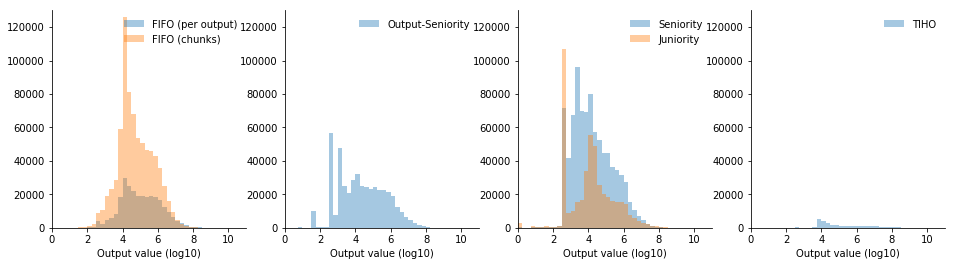

In [238]:
all_taint_value_hist(ofac_taint, 130000, "figures/ofac_taint_hist.pdf")

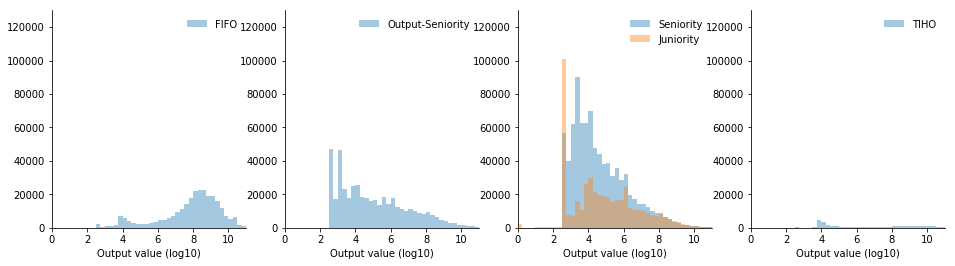

In [239]:
all_output_value_hist(ofac_taint, 130000, "figures/ofac_value_hist.pdf")

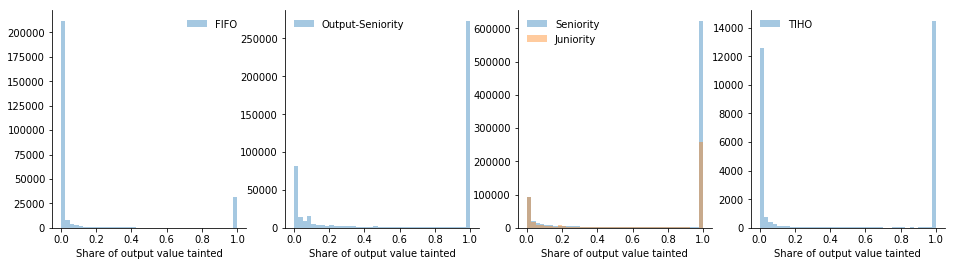

In [240]:
tainted_share_hist(ofac_taint, 650000, "figures/ofac_share_hist.pdf")

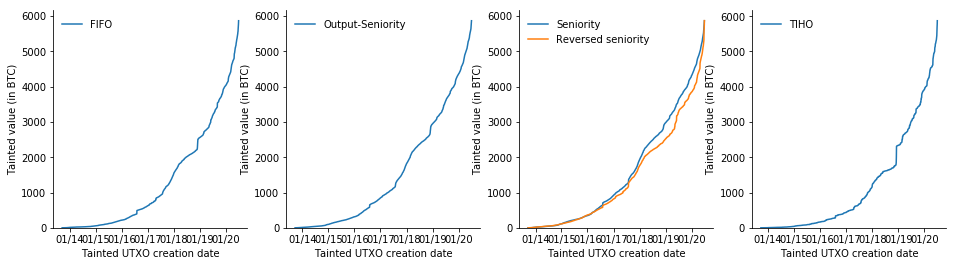

In [241]:
taint_age_lineplot(ofac_taint, filename="figures/ofac_age_lineplot.pdf")

### Ransomware

In [61]:
import csv

In [62]:
rw = set()
with open('data/cerber-locky-addresses.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        rw.add(chain.tx_with_hash(row[2]).outputs[int(row[3])])
rw = list(rw)

In [63]:
rw_minheight = min(o.tx.block_height for o in rw)

In [64]:
rw_maxheight = max(o.tx.block_height for o in rw)

In [65]:
%time ransomware_taint = run_taint(rw, max_height=max_height_analysis)

CPU times: user 5min 44s, sys: 2.34 s, total: 5min 46s
Wall time: 5min 49s


In [66]:
%time ransomware_taint_nofee = run_taint(rw, max_height=max_height_analysis, taint_fee=False)

CPU times: user 4min 12s, sys: 876 ms, total: 4min 12s
Wall time: 4min 11s


In [67]:
count_taint(ransomware_taint)

576,694 & 840,363 & 1,591,322 & 617,263 & 48,510


[576694, 840363, 1591322, 617263, 48510]

In [68]:
no_fee_taint_loss(ransomware_taint, ransomware_taint_nofee)

1.94 & 3.82 & 2.63 & 1.43 & 0.33


[(2241210679423, 2197784238829),
 (2236549158150, 2151156416058),
 (2237832847090, 2178888167797),
 (2240959072675, 2208865678063),
 (2244578619794, 2237068146743)]

In [ ]:
# count_taint(ransomware_taint)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


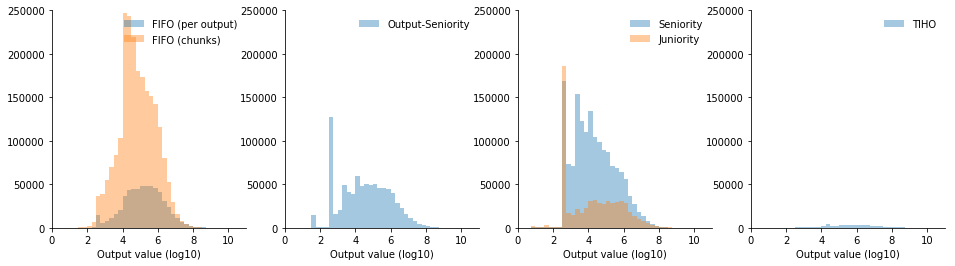

In [242]:
all_taint_value_hist(ransomware_taint, 250000, "figures/ransomware_taint_hist.pdf")

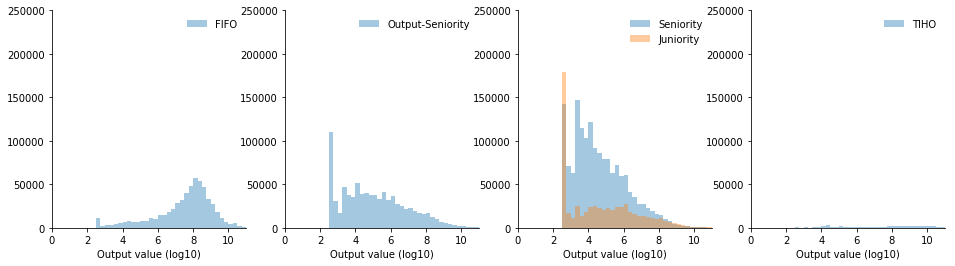

In [243]:
all_output_value_hist(ransomware_taint, 250000, "figures/ransomware_value_hist.pdf")

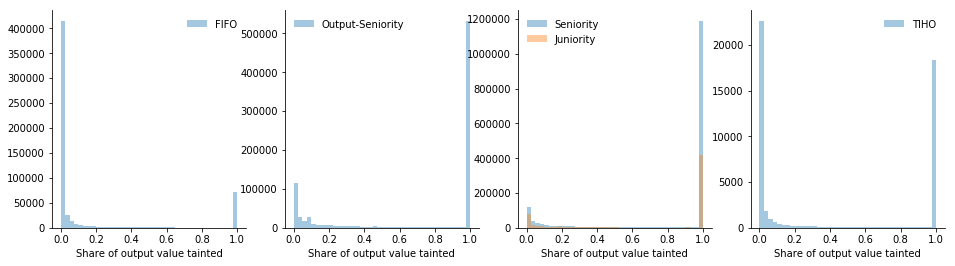

In [244]:
tainted_share_hist(ransomware_taint, 1200000, "figures/ransomware_share_hist.pdf")

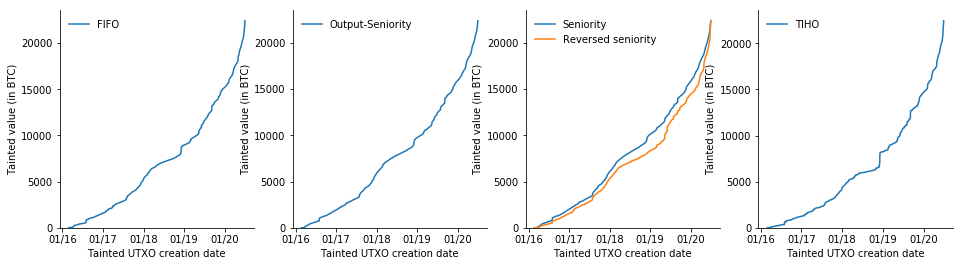

In [245]:
taint_age_lineplot(ransomware_taint, month_ticks=[1], filename="figures/ransomware_age_lineplot.pdf")

### Random Txes from 2019

In [69]:
rng2019 = chain.range("2019")

In [70]:
start_tx_index = rng2019[0].txes[0].index
start_tx_index

369239301

In [71]:
end_tx_index = rng2019[-1].txes[-1].index
end_tx_index

489022947

In [72]:
random.seed(20200908)
random_tx_indexes = [random.randint(start_tx_index, end_tx_index) for _ in range(1000)]

random_outs = []
for idx in random_tx_indexes:
    tx = chain.tx_with_index(idx)
    random_out = tx.outputs[random.randint(0, tx.output_count - 1)]
    if random_out.value > 100000:
        random_outs.append(random_out)
    if len(random_outs) == 100:
        break

In [73]:
len(random_outs)

100

In [75]:
300.07758293 == sum(x.value for x in random_outs) / 1e8

True

In [76]:
%time random_taint = run_taint(random_outs, max_height=max_height_analysis)

CPU times: user 52.8 s, sys: 376 ms, total: 53.2 s
Wall time: 53 s


In [77]:
count_taint(random_taint)

24,813 & 51,714 & 91,098 & 34,096 & 3,291


[24813, 51714, 91098, 34096, 3291]

In [78]:
%time random_taint_nofee = run_taint(random_outs, max_height=max_height_analysis, taint_fee=False)

CPU times: user 38.3 s, sys: 83.7 ms, total: 38.3 s
Wall time: 38.2 s


In [79]:
no_fee_taint_loss(random_taint, random_taint_nofee)

1.0 & 2.37 & 1.27 & 0.61 & 0.23


[(30007758293, 29706377272),
 (30007258976, 29296785867),
 (30007756982, 29626263148),
 (30006663663, 29822760084),
 (30005843271, 29936616229)]

In [ ]:
%time random_taint_full = run_taint(random_outs, runall=True, max_height=max_height_analysis)

#### Taint loss from ignoring fees

In [99]:
no_fee_taint_loss(random_taint, random_taint_nofee)

[3.01381021, 7.10473109, 3.81493834, 1.83903579, 0.69227042]
[0.010043436702511165, 0.023676708011492853, 0.012713173937953348, 0.006128757967409887, 0.0023071186960076685]


[(30007758293, 29706377272),
 (30007258976, 29296785867),
 (30007756982, 29626263148),
 (30006663663, 29822760084),
 (30005843271, 29936616229)]

### Poison/Haircut

In [139]:
%time random_poison_count = blocksci.heuristics.poison_tainted_output_count(random_outs)

CPU times: user 8min 41s, sys: 5.49 s, total: 8min 46s
Wall time: 8min 44s


In [140]:
%time random_haircut_count = blocksci.heuristics.haircut_tainted_output_count(random_outs)

CPU times: user 7min 52s, sys: 1.55 s, total: 7min 53s
Wall time: 7min 51s


In [141]:
random_poison_count, random_haircut_count

(25986492, 16800865)

### Value distribution among outputs

In [ ]:
%time chain[-1000:].map(lambda b: b.txes.outputs).where(lambda o: o.index < 10).group_by(lambda o: o.index, lambda p: p.value.sum)

In [ ]:
%time chain[-1000:].map(lambda b: b.txes.outputs.where(lambda o: o.index < 10)).group_by(lambda o: o.index, lambda p: p.value.sum)

In [ ]:
%time chain[-4032:].txes.where(lambda tx: tx.output_count == 2).outputs.group_by(lambda o: o.index, lambda p: p.value.sum)

In [ ]:
1337721614500628 / 649978488335706

### Plots

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


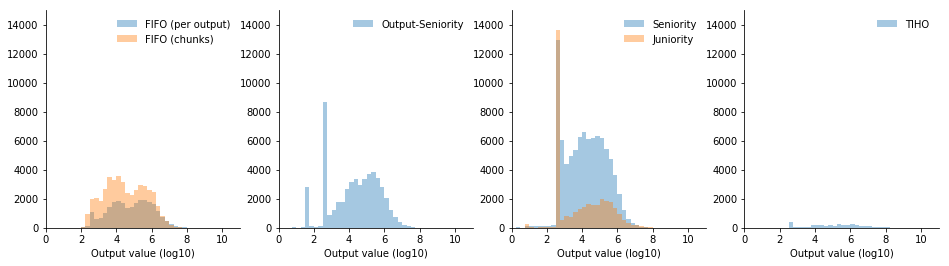

In [248]:
all_taint_value_hist(random_taint, 15000, "figures/random_taint_hist.pdf")

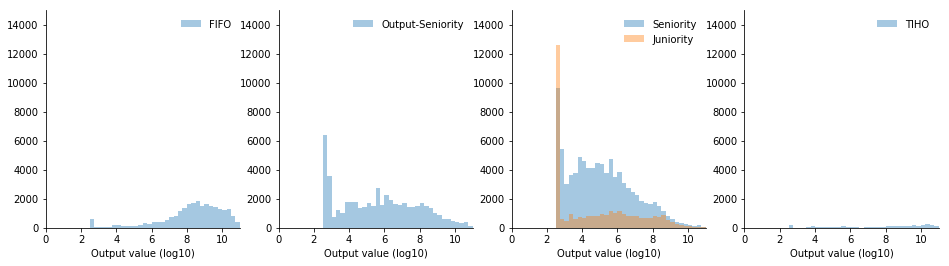

In [249]:
all_output_value_hist(random_taint, 15000, "figures/random_value_hist.pdf")

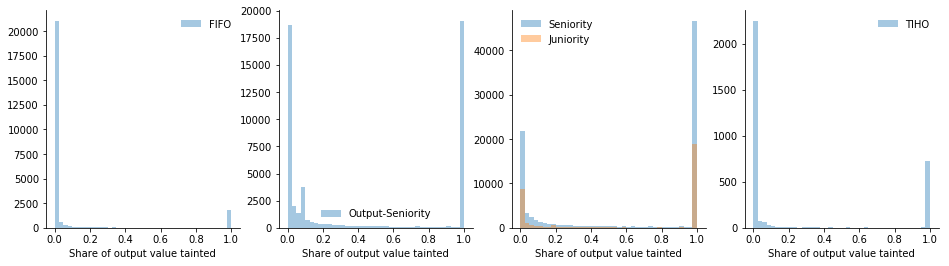

In [250]:
tainted_share_hist(random_taint, 50000, "figures/random_share_hist.pdf")

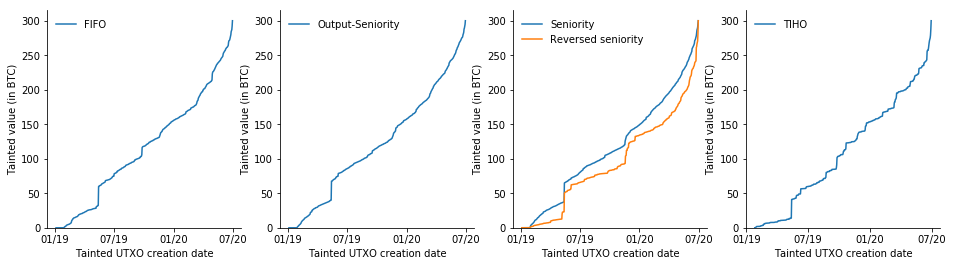

In [254]:
taint_age_lineplot(random_taint, month_ticks=[1,7], filename="figures/random_age_lineplot.pdf")

# 2 Week Analysis

## Blackmail

In [96]:
bm_2week_result = []
for o in blackmail_outs_nochange:
    r = run_taint([o], max_height=o.tx.block.height + 2016)
    bm_2week_result.append(count_taint(r, do_print=False))

In [124]:
latex_table_format(np.median(bm_2week_result, axis=0))

1.0 & 1.0 & 1.0 & 1.0 & 1.0


In [130]:
latex_table_format(np.mean(bm_2week_result, axis=0), round_digits=2)

2.4 & 5.2 & 6.6 & 3.66 & 1.25


## OFAC

In [97]:
ofac_2week_result = []
for o in ofac_outs:
    r = run_taint([o], max_height=o.tx.block.height + 2016)
    ofac_2week_result.append(count_taint(r, do_print=False))

In [133]:
latex_table_format(np.median(ofac_2week_result, axis=0))

5.0 & 10.0 & 14.0 & 32.0 & 1.0


In [134]:
latex_table_format(np.mean(ofac_2week_result, axis=0), round_digits=2)

27.68 & 45.43 & 64.45 & 238.14 & 9.39


## Ransomware

In [99]:
ransomware_2week_result = []
for o in rw:
    r = run_taint([o], max_height=o.tx.block.height + 2016)
    ransomware_2week_result.append(count_taint(r, do_print=False))

In [136]:
latex_table_format(np.median(ransomware_2week_result, axis=0))

2.0 & 10.0 & 14.0 & 4.0 & 2.0


In [135]:
latex_table_format(np.mean(ransomware_2week_result, axis=0), round_digits=2)

9.4 & 26.99 & 40.84 & 35.69 & 2.45


## Random

In [100]:
random_2week_result = []
for o in random_outs:
    r = run_taint([o], max_height=o.tx.block.height + 2016)
    random_2week_result.append(count_taint(r, do_print=False))

In [137]:
latex_table_format(np.median(random_2week_result, axis=0))

4.0 & 8.5 & 12.5 & 6.5 & 2.0


In [138]:
latex_table_format(np.mean(random_2week_result, axis=0), round_digits=2)

116.85 & 154.05 & 197.93 & 111.24 & 51.85


## Dataset stats

In [89]:
len(blackmail_outs_nochange)

273

In [90]:
output_time_range(blackmail_outs_nochange)

(datetime.datetime(2018, 4, 23, 11, 42, 24),
 datetime.datetime(2019, 4, 10, 17, 7, 47))

In [87]:
len(ofac_outs)

3305

In [88]:
output_time_range(ofac_outs)

(datetime.datetime(2013, 9, 6, 19, 6, 28),
 datetime.datetime(2020, 6, 29, 16, 33, 3))

In [84]:
len(rw)

16777

In [86]:
output_time_range(rw)

(datetime.datetime(2016, 2, 11, 8, 32, 47),
 datetime.datetime(2017, 8, 31, 6, 53, 46))

In [83]:
len(random_outs)

100

In [82]:
output_time_range(random_outs)

(datetime.datetime(2019, 1, 2, 15, 34),
 datetime.datetime(2019, 12, 26, 15, 3, 33))

## FIFO Chunk Counts

In [220]:
len(blackmail_taint[0]), fifo_chunk_count(blackmail_taint[0])

(2821, 3428)

In [221]:
len(ofac_taint[0]), fifo_chunk_count(ofac_taint[0])

(270537, 764601)

In [232]:
len(ransomware_taint[0]), fifo_chunk_count(ransomware_taint[0])

(576694, 2221476)

In [233]:
len(random_taint[0]), fifo_chunk_count(random_taint[0])

(24813, 44472)